#### Joseph O'Malley
Dec-2018

<h1 id="tocheading"> Image Classification - Histopathologic Cancer Detection (using Tensorflow w Keras)</h1>
<div id="toc"></div>

In [1]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

## Overview

### Histopathologic Cancer Detection Dataset
"For this Kaggle competition, you must create an algorithm to identify metastatic cancer in small image patches taken from larger digital pathology scans. The data for this competition is a slightly modified version of the PatchCamelyon (PCam) benchmark dataset (removing the duplicates).  PCam (https://camelyon16.grand-challenge.org/Home/) packs the clinically-relevant task of metastasis detection into a straight-forward binary image classification task."

The dataset includes 200,025 training images and 57,458 test images (with test predictions to be submitted for the competition).  The class balance of the training data is fairly even with 40.5% cancer positive cases (89,117 of the total 220,025).

### Methods
For this image classification task I created a Convolutional Neural Network (CNN) using a combination of Google's TensorFlow Machine learning with Keras as a wrapper that makes implementations of these very complex machine learning more simple.  You are now able to work with Keras out of Python (Jupyter Notebooks).  With a growing developer community, there are many examples that help make implementing these complex algorithms efficient and effective.   

In [2]:
## Load required packages
from numpy.random import seed
seed(101)
from tensorflow import set_random_seed
set_random_seed(101)

import pandas as pd
import numpy as np


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

import os
import cv2

from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import itertools
import shutil
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("always")

/Users/ultrajosef/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/ultrajosef/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/ultrajosef/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/ultrajosef/anaconda3/lib/python3.6/site-packages/tensorflow/

## Exploratory Data Analysis

#### Import Images

In [3]:
## specify folder path in your local drive
path = "/local/file/path/"

## view list of files in local project folder to find images
os.listdir(path)

['train_labels.csv',
 '.DS_Store',
 'test',
 'BIA6305_inst.pem',
 'OMalley_6303_final.zip',
 'BIA6303_JO_HistopathologicCancerDetection_Final.html',
 'Screen Shot 2018-12-09 at 6.42.35 PM.png',
 'train',
 'BIA6305_inst.pem.txt',
 'sample_submission.csv']

In [4]:
## print number of images in each respective set
print(len(os.listdir(path +'train')))
print(len(os.listdir(path + 'test')))

220025
57458


In [5]:
## import training data labels
df_data = pd.read_csv(path + 'train_labels.csv')

# removing this image because it caused a training error previously
df_data[df_data['id'] != 'dd6dfed324f9fcb6f93f46f32fc800f2ec196be2']
# removing this image because it's black
df_data[df_data['id'] != '9369c7278ec8bcc6c880d99194de09fc2bd4efbe']

## check shape of df of images
print(df_data.shape)

(220025, 2)


In [6]:
## check split of labels (1 = cancer positive)
df_data['label'].value_counts()

0    130908
1     89117
Name: label, dtype: int64

#### Visualize Images

In [7]:
##create function for visualizing images
# source: https://www.kaggle.com/gpreda/honey-bee-subspecies-classification

def draw_category_images(col_name,figure_cols, df, IMAGE_PATH):
    
    """
    Give a column in a dataframe,
    this function takes a sample of each class and displays that
    sample on one row. The sample size is the same as figure_cols which
    is the number of columns in the figure.
    Because this function takes a random sample, each time the function is run it
    displays different images.
    """
    

    categories = (df.groupby([col_name])[col_name].nunique()).index
    f, ax = plt.subplots(nrows=len(categories),ncols=figure_cols, 
                         figsize=(4*figure_cols,4*len(categories))) # adjust size here
    # draw a number of images for each location
    for i, cat in enumerate(categories):
        sample = df[df[col_name]==cat].sample(figure_cols) # figure_cols is also the sample size
        for j in range(0,figure_cols):
            file=IMAGE_PATH + sample.iloc[j]['id'] + '.tif'
            im=cv2.imread(file)
            ax[i, j].imshow(im, resample=True, cmap='gray')
            ax[i, j].set_title(cat, fontsize=16)  
    plt.tight_layout()
    plt.show()

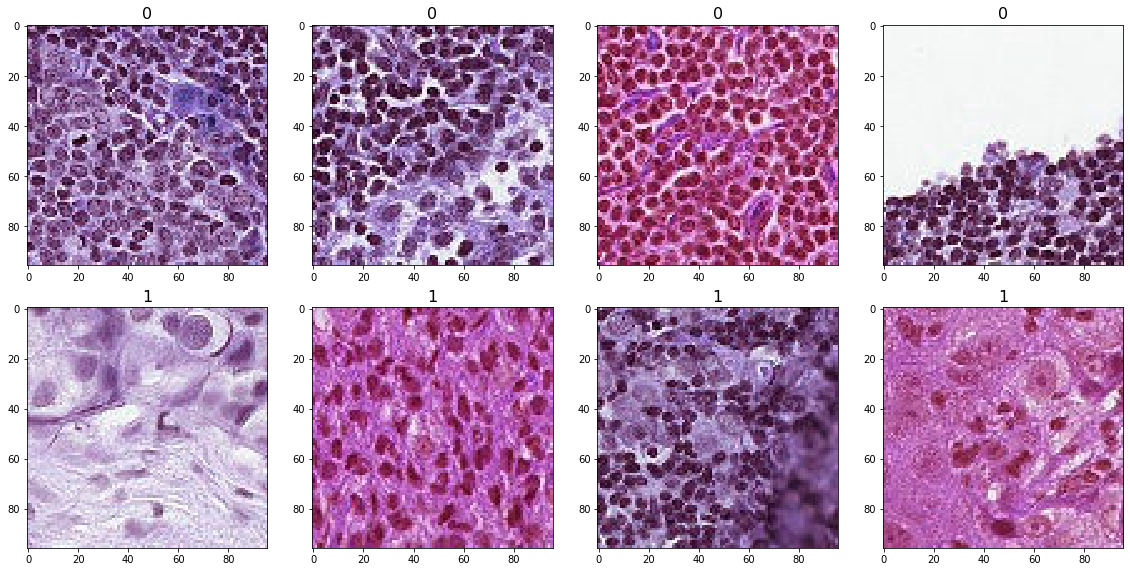

In [8]:
IMAGE_PATH = path + 'train/' 

draw_category_images('label',4, df_data, IMAGE_PATH)

##### Analysis of Images

As we can see from this sample of images, there is a fair amount of variety in the apparent types (size, spacing, etc.) of cells and the coloration. The coloration occurs during the preparation of histological slides, different stains can be used for various purposes. The hematoxylin and eosin (H&E) stain is most widely used. It induces sharp blue/pink contrasts across various (sub)cellular structures and it is applied across many different tissue types.  For this reason, I will not convert these images to grayscale.  Though it would make it much less computationally intensive, I beleive we will lose some predictive power.

## Model Building

### Create Train & Test sets

In [9]:
## equals number of pixels per image
IMAGE_SIZE = 96
## represents number of dimensions per pixel. 3 is for color images
IMAGE_CHANNELS = 3

In [10]:
df_data.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


### Target Distribution

With 40.5% of the data being positive cases (with metastases), this is a good split to train on.  There isnt a hard and fast rule about balancing data, but with a training set this large there will be plenty of positive cases to train on (89,117 to be exact).  Creating an even split of data would throw out 41,791 images at a minimum.  It would have made it slightly less computationally intensive and still achieved a respectable accuracy in my ititial run of 93.3% accuracy.  However, there is no subsititute for more data to train on, so I will move forward with the full training set. For the holdout validation set, I will take 8% of the training set which represents 17,602 images.     


In [11]:
# shuffle data to ensure that image types are randomly distributed for our validation and traing sets
df_data = shuffle(df_data)

df_data['label'].value_counts()

0    130908
1     89117
Name: label, dtype: int64

In [12]:
# train_test_split
y = df_data['label']

## split dataset to hold out 10% of observations for validation 
df_train, df_val = train_test_split(df_data, test_size=0.08, random_state=101, stratify=y)

print(df_train.shape)
print(df_val.shape)

(202423, 2)
(17602, 2)


In [13]:
## check for representative splits in each dataset (~40/60)
df_train['label'].value_counts()

0    120435
1     81988
Name: label, dtype: int64

In [14]:
## check for representative splits in each dataset (~40/60)
df_val['label'].value_counts()

0    10473
1     7129
Name: label, dtype: int64

Training and validation set result in representative splits (each with 40.5% positives)

### Create a Directory Structure

In [19]:
# Create a new directory
base_dir = 'base_dir'
os.mkdir(base_dir)


#[CREATE FOLDERS INSIDE THE BASE DIRECTORY]

# create a path to 'base_dir' to which we will join the names of the new folders
# train_dir
train_dir = os.path.join(base_dir, 'train_dir')
os.mkdir(train_dir)

# val_dir
val_dir = os.path.join(base_dir, 'val_dir')
os.mkdir(val_dir)



# [CREATE FOLDERS INSIDE THE TRAIN AND VALIDATION FOLDERS]
# Inside each folder we create seperate folders for each class

# create new folders inside train_dir
no_tumor_tissue = os.path.join(train_dir, 'a_no_tumor_tissue')
os.mkdir(no_tumor_tissue)
has_tumor_tissue = os.path.join(train_dir, 'b_has_tumor_tissue')
os.mkdir(has_tumor_tissue)


# create new folders inside val_dir
no_tumor_tissue = os.path.join(val_dir, 'a_no_tumor_tissue')
os.mkdir(no_tumor_tissue)
has_tumor_tissue = os.path.join(val_dir, 'b_has_tumor_tissue')
os.mkdir(has_tumor_tissue)

In [20]:
# check that the folders have been created
os.listdir('base_dir/train_dir')

['a_no_tumor_tissue', 'b_has_tumor_tissue']

#### Transfer the images into the folders

In [21]:
# Set the id as the index in df_data
df_data.set_index('id', inplace=True)

In [23]:
# Get a list of train and val images
train_list = list(df_train['id'])
val_list = list(df_val['id'])



# Transfer the train images

for image in train_list:
    
    # the id in the csv file does not have the .tif extension therefore we add it here
    fname = image + '.tif'
    # get the label for a certain image
    target = df_data.loc[image,'label']
    
    # these must match the folder names
    if target == 0:
        label = 'a_no_tumor_tissue'
    if target == 1:
        label = 'b_has_tumor_tissue'
    
    # source path to image
    src = os.path.join(path + 'train', fname)
    # destination path to image
    dst = os.path.join(train_dir, label, fname)
    # copy the image from the source to the destination
    shutil.copyfile(src, dst)


# Transfer the val images

for image in val_list:
    
    # the id in the csv file does not have the .tif extension therefore we add it here
    fname = image + '.tif'
    # get the label for a certain image
    target = df_data.loc[image,'label']
    
    # these must match the folder names
    if target == 0:
        label = 'a_no_tumor_tissue'
    if target == 1:
        label = 'b_has_tumor_tissue'
    

    # source path to image
    src = os.path.join(path + 'train', fname)
    # destination path to image
    dst = os.path.join(val_dir, label, fname)
    # copy the image from the source to the destination
    shutil.copyfile(src, dst)

In [24]:
# check how many train images we have in each folder

print(len(os.listdir('base_dir/train_dir/a_no_tumor_tissue')))
print(len(os.listdir('base_dir/train_dir/b_has_tumor_tissue')))

126095
87764


In [25]:
# check how many val images we have in each folder

print(len(os.listdir('base_dir/val_dir/a_no_tumor_tissue')))
print(len(os.listdir('base_dir/val_dir/b_has_tumor_tissue')))

10473
7129


### Set Up the Generators

In [26]:
train_path = 'base_dir/train_dir'
valid_path = 'base_dir/val_dir'
test_path = 'test'

## get counts of observations in both training and validation sets
num_train_samples = len(df_train)
num_val_samples = len(df_val)

## Choose to create larger batches (of 32) to help the ease of computation.  
train_batch_size = 32
val_batch_size = 32
batch_size = 32

## calculates number of steps needed per epoch
train_steps = np.ceil(num_train_samples / train_batch_size)
val_steps = np.ceil(num_val_samples / val_batch_size)

In [27]:
## Rescale Image data from 0-255 (which represents the range of RGB values), to a 0-1 scale
## this will help the Nueral net to run more efficiently
datagen = ImageDataGenerator(rescale=1.0/255)

train_gen = datagen.flow_from_directory(train_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=train_batch_size,
                                        class_mode='categorical')

val_gen = datagen.flow_from_directory(valid_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=val_batch_size,
                                        class_mode='categorical')

# Note: shuffle=False causes the test dataset to not be shuffled
test_gen = datagen.flow_from_directory(valid_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=1,
                                        class_mode='categorical',
                                        shuffle=False)

Found 213859 images belonging to 2 classes.
Found 17602 images belonging to 2 classes.
Found 17602 images belonging to 2 classes.


### Create the Model Architecture

This is where a majority of the tunings happen. I am computationally constrained running this on my CPU.  This limits my ability to add many layers to my Convolutional Nueral Network.  Running these programs on a GPU would be exponentially faster, as it is able to be processed in parralel and would allow me to create models with more layers and epochs. I explored using an external GPU (including Google Colab - a free GPU environment that runs python notebooks), but was not able to get the full set of images into Google Drive (which feeds Google Collab).  Other GPU options required payment and additional set-up time.

#### Parameter Settings:


**Kernal size** - is the size of the convolutional filters. They are mostly square in practice

**Pool size** - integer or tuple of 2 integers, factors by which to downscale (vertical, horizontal). (2, 2) will halve the input in both spatial dimensions.  This effectively downsamples and makes the model more efficient.

**Filters** - equals number of channels in output of convolutional layer

**Dropout rate** - dropout randomly sets a fraction rate of input units to 0 at each update during training time, which helps prevent overfitting.

**Conv2D** - is used with kernals that slide across 2 dimensions.  In this case its color images.

**Strides** - Specifies the amount that each kernal is iteratively shifted, with a smaller number representing smaller shifts.

**Activation function** - 'relu' is more optimal for the hidden layers and 'softmax' is best for the output layer.

In [30]:
kernel_size = (3,3)
pool_size= (2,2)
strides=(1, 1)
first_filters = 15
second_filters = 30
third_filters = 60
fourth_filters = 120

dropout_conv1 = 0.4
dropout_conv2 = 0.3
dropout_conv3 = 0.2
dropout_conv4 = 0.2
dropout_dense = 0.1


model = Sequential()
model.add(Conv2D(first_filters, kernel_size = kernel_size, strides=strides, activation = 'relu', input_shape = (96, 96, 3)))
model.add(Conv2D(first_filters, kernel_size = kernel_size, strides=strides, activation = 'relu'))
model.add(MaxPooling2D(pool_size = pool_size)) 
model.add(Dropout(dropout_conv1))

model.add(Conv2D(second_filters, strides=strides, kernel_size = kernel_size, activation ='relu'))
model.add(MaxPooling2D(pool_size = pool_size))
model.add(Dropout(dropout_conv2))

model.add(Conv2D(third_filters, strides=strides, kernel_size = kernel_size, activation ='relu'))
model.add(MaxPooling2D(pool_size = pool_size))
model.add(Dropout(dropout_conv3))

model.add(Conv2D(fourth_filters, strides=strides, kernel_size = kernel_size, activation ='relu'))
model.add(MaxPooling2D(pool_size = pool_size))
model.add(Dropout(dropout_conv4))

model.add(Flatten())
model.add(Dense(180, activation = "relu"))
model.add(Dropout(dropout_dense))
model.add(Dense(2, activation = "softmax"))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 94, 94, 15)        420       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 92, 92, 15)        2040      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 46, 46, 15)        0         
_________________________________________________________________
dropout (Dropout)            (None, 46, 46, 15)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 44, 44, 30)        4080      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 22, 22, 30)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 22, 22, 30)        0         
__________

/Users/ultrajosef/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/tensor_util.py:542: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  append_fn(tensor_proto, proto_values)


## Train the Model

#### Parameter Settings:

**Adam** - is a method of Stochastic Optimization

**lr** - the "Learning Rate" that specifies the size of the "steps" when trying to find local and global minimums (for validation loss).  Smaller lr may miss less, but are more computationally intense.

**loss function** - binary cross entropy, which measures true positives to predicted positives

**metric** - specifies that the "accuracy" metric is a function that is used to judge the performance of your model. Metric functions are to be supplied in the metrics parameter when a model is compiled.

**monitor** - "val_acc" checks to see is validation accuracy is improving (that it's "max).  If not it reverts to the previous version.  The other popular option here is to minimize validation loss

**ReduceLROnPlateau** - Reduce learning rate when a metric has stopped improving. This callback monitors a quantity and if no improvement is seen for a 'patience' number of epochs, the learning rate is reduced.

**min_lr** - In min mode, lr will be reduced when the quantity (accuracy in this case) monitored has stopped decreasing

**epochs** - The number of epochs means how many sperate times you go through your training dataset.  I set this at 5, as this argument has by far the largest effect on run time.


In [31]:
## increased the learning rate to help the model run more quickly
model.compile(Adam(lr=0.0005), loss='binary_crossentropy', 
              metrics=['accuracy'])

In [32]:
# Get the labels that are associated with each index
print(val_gen.class_indices)

{'a_no_tumor_tissue': 0, 'b_has_tumor_tissue': 1}


In [33]:
filepath = "model.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, 
                             save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=2, 
                                   verbose=1, mode='max', min_lr=0.00002)
                              
                              
callbacks_list = [checkpoint, reduce_lr]

history = model.fit_generator(train_gen, steps_per_epoch=train_steps, 
                    validation_data=val_gen,
                    validation_steps=val_steps,
                    epochs=5, verbose=1,
                   callbacks=callbacks_list)

Epoch 1/5
6325/6326 [============================>.] - ETA: 0s - loss: 0.4189 - acc: 0.8116
Epoch 00001: val_acc improved from -inf to 0.78139, saving model to model.h5
6326/6326 [==============================] - 3127s 494ms/step - loss: 0.4189 - acc: 0.8116 - val_loss: 0.4370 - val_acc: 0.7814
Epoch 2/5
6325/6326 [============================>.] - ETA: 0s - loss: 0.3431 - acc: 0.8515
Epoch 00002: val_acc improved from 0.78139 to 0.83280, saving model to model.h5
6326/6326 [==============================] - 3224s 510ms/step - loss: 0.3431 - acc: 0.8515 - val_loss: 0.3706 - val_acc: 0.8328
Epoch 3/5
6325/6326 [============================>.] - ETA: 0s - loss: 0.3131 - acc: 0.8665
Epoch 00003: val_acc improved from 0.83280 to 0.87115, saving model to model.h5
6326/6326 [==============================] - 3450s 545ms/step - loss: 0.3131 - acc: 0.8665 - val_loss: 0.3047 - val_acc: 0.8712
Epoch 4/5
6325/6326 [============================>.] - ETA: 0s - loss: 0.2927 - acc: 0.8774
Epoch 00004

In [34]:
tf.__version__

'1.12.0'

**Run time:** this model took 6.5 hours to run with 5 epochs.

### Evaluate the model using the validation set

I used loss and accuracy as the measures of accuracy on the 8% (17,602 images) of data that was held out in the validation set.

In [35]:
# get the metric names so we can use evaulate_generator
model.metrics_names

['loss', 'acc']

In [36]:
# Here the best epoch will be used.

model.load_weights('model.h5')

val_loss, val_acc = \
model.evaluate_generator(test_gen, 
                        steps=len(df_val))

print('val_loss:', val_loss)
print('val_acc:', val_acc)

val_loss: 0.3046775749257514
val_acc: 0.8711510055675491


### Plot the Training Curves

<Figure size 432x288 with 0 Axes>

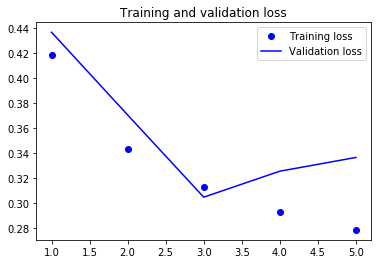

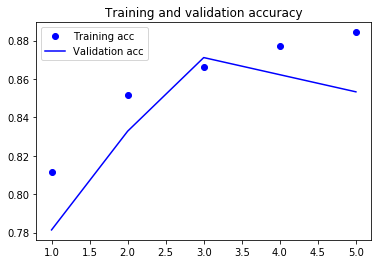

<Figure size 432x288 with 0 Axes>

In [37]:
# display the loss and accuracy curves

import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

We can see that the validation holdout set did not perform as well as either metric in the training set.  It did follow the same general trend and the scales of the graphs do exaggerate the differences.  For both measures there appears to be a diminishing return with each subsequent epoch, as would be expected. 

### Make a prediction on the test set


In [38]:
# make a prediction
predictions = model.predict_generator(test_gen, steps=len(df_val), verbose=1)

17602/17602 [==============================] - 141s 8ms/step


In [39]:
predictions.shape

(17602, 2)

**Keras class index values:** Keras assigns it's own index value (here 0 and 1) to the classes. It infers the classes based on the folder structure. Important: These index values may not match the index values we were given in the train_labels.csv file.  Using the 'a' and 'b' folder name pre-fixes to get keras to assign index values to match what was in the train_labels.csv file is a guess that keras is assigning the index value based on folder name alphabetical order.

In [40]:
# This is how to check what index keras has internally assigned to each class. 
test_gen.class_indices

{'a_no_tumor_tissue': 0, 'b_has_tumor_tissue': 1}

In [41]:
# Put the predictions into a dataframe.
# The columns need to be oredered to match the output of the previous cell

df_preds = pd.DataFrame(predictions, columns=['no_tumor_tissue', 'has_tumor_tissue'])

df_preds.head()

,no_tumor_tissue,has_tumor_tissue
0,0.994087,0.005914
1,0.952211,0.047789
2,0.950987,0.049013
3,0.089310,0.910690
4,0.693785,0.306215


In [77]:
# Get the true labels
y_true = test_gen.classes

# Get the predicted labels as probabilities
y_pred = df_preds['has_tumor_tissue']

#### Area Under the Curve (AUC)

This measures the trade off between catching all of the true positives and the rate at ahich you do it (without picking up noise in the form of false positives).

In [43]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_true, y_pred)

0.9443331473351436

In [94]:
## plot AU-ROC

from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_true, y_pred)

def plot_roc_curve(fpr,tpr): 
  plt.plot(fpr,tpr) 
  plt.axis([0,1,0,1]) 
  plt.xlabel('False Positive Rate') 
  plt.ylabel('True Positive Rate') 
  plt.show()    
  
plot_roc_curve(fpr,tpr) 

In [70]:
y_pred.head()

0    0.932577
1    0.991427
2    0.740577
3    0.557321
4    0.034067
Name: has_tumor_tissue, dtype: float32

##### Create a Confusion Matrix

In [44]:
# Source: Scikit Learn website
# http://scikit-learn.org/stable/auto_examples/
# model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-
# selection-plot-confusion-matrix-py


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [45]:
# Get the labels of the test images.

test_labels = test_gen.classes

In [46]:
test_labels.shape

(17602,)

In [47]:
# argmax returns the index of the max value in a row
cm = confusion_matrix(test_labels, predictions.argmax(axis=1))

# Print the label associated with each class
test_gen.class_indices

{'a_no_tumor_tissue': 0, 'b_has_tumor_tissue': 1}

Confusion matrix, without normalization
[[9044 1429]
 [ 839 6290]]


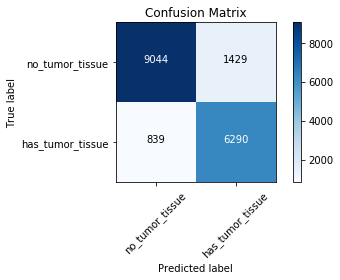

In [48]:
# Define the labels of the class indices. These need to match the 
# order shown above.
cm_plot_labels = ['no_tumor_tissue', 'has_tumor_tissue']

plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')

##### Create a Classification Report

In [49]:
from sklearn.metrics import classification_report

# Generate a classification report

# For this to work we need y_pred as binary labels not as probabilities
y_pred_binary = predictions.argmax(axis=1)

report = classification_report(y_true, y_pred_binary, target_names=cm_plot_labels)

print(report)

                  precision    recall  f1-score   support

 no_tumor_tissue       0.92      0.86      0.89     10473
has_tumor_tissue       0.81      0.88      0.85      7129

        accuracy                           0.87     17602
       macro avg       0.86      0.87      0.87     17602
    weighted avg       0.87      0.87      0.87     17602



### Validation Performance

The model performed well on the validation set and caught 88% of the true positive images that we were most concerned with.  It did this while only picking up some noise as 82% of the metasteses it predicted actually were (while they only made up 40.5% of the dataset, which is significant lift).  Overall, the model achieved 88% accuracy on the validation set.  As we held out observations in each of the epochs to prevent overfitting, it will be interesting to see how this model performs on the test data.

## Make Test Set Predictions

In [50]:
# Delete base_dir and it's sub folders to free up disk space.

shutil.rmtree('base_dir')

In [53]:
#[CREATE A TEST FOLDER DIRECTORY STRUCTURE]

# We will be feeding test images from a folder into predict_generator().
# Keras requires that the path should point to a folder containing images and not
# to the images themselves. That is why we are creating a folder (test_images) 
# inside another folder (test_dir).

# test_dir
    # test_images

# create test_dir
test_dir = 'test_dir'
os.mkdir(test_dir)
    
# create test_images inside test_dir
test_images = os.path.join(test_dir, 'test_images')
os.mkdir(test_images)

In [54]:
# check that the directory we created exists
os.listdir('test_dir')

['test_images']

In [55]:
# Transfer the test images into image_dir

test_list = os.listdir(path + 'test')

for image in test_list:
    
    fname = image
    
    # source path to image
    src = os.path.join(path + 'test', fname)
    # destination path to image
    dst = os.path.join(test_images, fname)
    # copy the image from the source to the destination
    shutil.copyfile(src, dst)

In [56]:
# check that the images are now in the test_images
# Should now be 57458 images in the test_images folder

len(os.listdir('test_dir/test_images'))

57458

### Set up the generator

In [57]:
test_path ='test_dir'


# Here we change the path to point to the test_images folder.

test_gen = datagen.flow_from_directory(test_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=1,
                                        class_mode='categorical',
                                        shuffle=False)

Found 57458 images belonging to 1 classes.


#### Make a prediction on the test images

In [58]:
num_test_images = 57458

# make sure we are using the best epoch
model.load_weights('model.h5')

predictions = model.predict_generator(test_gen, steps=num_test_images, verbose=1)

57458/57458 [==============================] - 460s 8ms/step


In [59]:
# Are the number of predictions correct?
# Should be 57458.

len(predictions)

57458

In [60]:
# Put the predictions into a dataframe
df_preds = pd.DataFrame(predictions, columns=['no_tumor_tissue', 'has_tumor_tissue'])

# Model assigns probabilistic chance that a given obs falls into each of the respective classes
df_preds.head()

,no_tumor_tissue,has_tumor_tissue
0,0.067423,0.932577
1,0.008573,0.991427
2,0.259423,0.740577
3,0.442679,0.557321
4,0.965933,0.034067


In [61]:
# This outputs the file names in the sequence in which 
# the generator processed the test images.
test_filenames = test_gen.filenames

# add the filenames to the dataframe
df_preds['file_names'] = test_filenames

df_preds.head()

,no_tumor_tissue,has_tumor_tissue,file_names
0,0.067423,0.932577,test_images/00006537328c33e284c973d7b39d340809...
1,0.008573,0.991427,test_images/0000ec92553fda4ce39889f9226ace43ca...
2,0.259423,0.740577,test_images/00024a6dee61f12f7856b0fc6be20bc7a4...
3,0.442679,0.557321,test_images/000253dfaa0be9d0d100283b22284ab2f6...
4,0.965933,0.034067,test_images/000270442cc15af719583a8172c87cd2bd...


In [62]:
# Create an id column

# A file name now has this format: 
# test_images/00006537328c33e284c973d7b39d340809f7271b.tif

# This function will extract the id:
# 00006537328c33e284c973d7b39d340809f7271b

def extract_id(x):
    
    # split into a list
    a = x.split('/')
    # split into a list
    b = a[1].split('.')
    extracted_id = b[0]
    
    return extracted_id

df_preds['id'] = df_preds['file_names'].apply(extract_id)

df_preds.head()

,no_tumor_tissue,has_tumor_tissue,file_names,id
0,0.067423,0.932577,test_images/00006537328c33e284c973d7b39d340809...,00006537328c33e284c973d7b39d340809f7271b
1,0.008573,0.991427,test_images/0000ec92553fda4ce39889f9226ace43ca...,0000ec92553fda4ce39889f9226ace43cae3364e
2,0.259423,0.740577,test_images/00024a6dee61f12f7856b0fc6be20bc7a4...,00024a6dee61f12f7856b0fc6be20bc7a48ba3d2
3,0.442679,0.557321,test_images/000253dfaa0be9d0d100283b22284ab2f6...,000253dfaa0be9d0d100283b22284ab2f6b643f6
4,0.965933,0.034067,test_images/000270442cc15af719583a8172c87cd2bd...,000270442cc15af719583a8172c87cd2bd9c7746


In [63]:
# Get the predicted labels.
# We were asked to predict a probability that the image has tumor tissue
y_pred = df_preds['has_tumor_tissue']

# get the id column
image_id = df_preds['id']

### Create a submission file

In [64]:
submission = pd.DataFrame({'id':image_id, 
                           'label':y_pred, 
                          }).set_index('id')

submission.to_csv('cancerDetection_predictions.csv', columns=['label']) 

In [65]:
submission.head()

,label
id,
00006537328c33e284c973d7b39d340809f7271b,0.932577
0000ec92553fda4ce39889f9226ace43cae3364e,0.991427
00024a6dee61f12f7856b0fc6be20bc7a48ba3d2,0.740577
000253dfaa0be9d0d100283b22284ab2f6b643f6,0.557321
000270442cc15af719583a8172c87cd2bd9c7746,0.034067


In [66]:
# Delete the test_dir directory we created to prevent a Kaggle error.
# Kaggle allows a max of 500 files to be saved.

shutil.rmtree('test_dir')

### Test set performance 

The second run of the model the full training data with 5 epochs achieved an accuracy of 94.28%.  This is nearly a full 1% (~578 images) improvement over my first attempt using 4 epochs and an even subset of the entire training set.  It is also significantly better than the small holdout validation set (88%).

This submission had me last ranked at 740/1157: https://www.kaggle.com/c/histopathologic-cancer-detection/leaderboard

#### Reference Kernels

These code/methods helped to create my model:

Marsh, CNN - How to use 160,000 images without crashing
https://www.kaggle.com/vbookshelf/cnn-how-to-use-160-000-images-without-crashing

Gabriel Preda, Honey Bee Subspecies Classification 
https://www.kaggle.com/gpreda/honey-bee-subspecies-classification

Beluga, Black and White CNN
https://www.kaggle.com/gaborfodor/black-white-cnn-lb-0-77

Francesco Marazzi, Baseline Keras CNN
https://www.kaggle.com/fmarazzi/baseline-keras-cnn-roc-fast-5min-0-8253-lb